# Анализ сервиса аренды самокатов GoFast

## Описание проекта

Данный проект подразумевает под собой общий анализ сервиса по аренде электросамокатов и проверке гипотез о том, какие пользователи прибыльнее для компании - с подпиской или без нее.

## Цель проекта

Выяснить являются ли пользователи с подпиской "выгоднее" для компании.

## Описание данных

В основных данных есть информация о пользователях, их поездках и подписках. Это 3 разных набора данных. Первый даёт базовое представление о пользователях(id, имя, возраст, город проживания и тип подписки). Второй даёт конкретную информацию о поездках(id, расстояние, время и дату совершения поездки). А третий даёт исключительно информацию о тарифах для каждого типа подписок.

## План работы

1. Загрузить данные и изучить информацию о них. Так же изучить данные на предмет аномалий.
2. Предобработка данных. Уничтожение всех аномалий.
3. Описание и визуализация информации о пользователях и поездках.
4. Обьединение всех данных в 1 датафрейм и создание двух новых датафреймов(с платными и бесплатными подписчиками), а так же их визуализация.
5. Создание нового датафрейма с агрегированными данными(суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц) и добавление в него столбца с помесячной выручкой от каждого клиента.
6. Проверка нескольких гипотез о прибыльности платных подписчиков

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
pd.options.mode.chained_assignment = None

#### Шаг 1. Загрузка данных

31
   user_id        name  age            city subscription_type
0        1        Кира   22          Тюмень             ultra
1        2   Станислав   31            Омск             ultra
2        3     Алексей   20          Москва             ultra
3        4  Константин   26  Ростов-на-Дону             ultra
4        5       Адель   28            Омск             ultra
5        6      Регина   25       Краснодар             ultra
6        7       Игорь   23            Омск             ultra
7        8        Юрий   23       Краснодар             ultra
8        9          Ян   21       Пятигорск             ultra
9       10     Валерий   18    Екатеринбург             ultra
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age             

<Axes: >

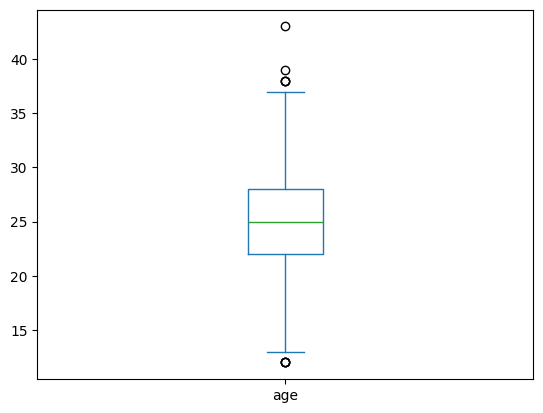

In [2]:
#анализируем 1 набор данных
filepath = r"C:\Users\erofe\Downloads\users_go.csv"
data_users = pd.read_csv(filepath, sep=',')
#ищем дубликаты
print(data_users.duplicated().sum())
#выводим первые 10 строк таблицы
print(data_users.head(10))
#выводим информацию о таблице
print(data_users.info())
#строим диаграмму размаха для единственного числового столбца
data_users['age'].plot(kind = 'box')

В данном датафрейме не имеется пропущенных значений. Присутствуют выбросы в единственном числовом столбце(возраст) и дубликаты. Все будет исправлено в предобработке данных.

0
   user_id     distance   duration        date
0        1  4409.919140  25.599769  2021-01-01
1        1  2617.592153  15.816871  2021-01-18
2        1   754.159807   6.232113  2021-04-20
3        1  2694.783254  18.511000  2021-08-11
4        1  4028.687306  26.265803  2021-08-28
5        1  2770.890808  16.650138  2021-10-09
6        1  3039.020292  14.927879  2021-10-19
7        1  2842.118050  23.117468  2021-11-06
8        1  3412.690668  15.238072  2021-11-14
9        1   748.690645  15.041884  2021-11-22
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
None


<Axes: >

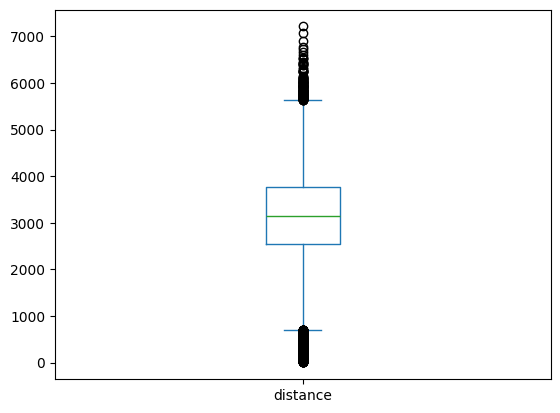

In [3]:
#анализируем 2 набор данных
filepath = r"C:\Users\erofe\Downloads\rides_go.csv"
data_rides = pd.read_csv(filepath, sep=',')
#ищем дубликаты
print(data_rides.duplicated().sum())
#выводим первые 10 строк таблицы
print(data_rides.head(10))
#выводим информацию о таблице
print(data_rides.info())
#строим диаграмму размаха для столбца с расстоянием поездки
data_rides['distance'].plot(kind = 'box')

<Axes: >

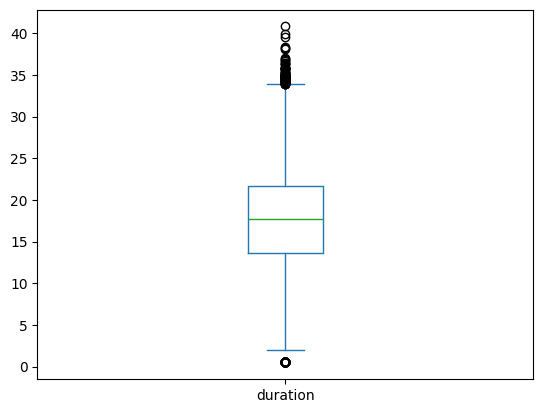

In [4]:
#строим диаграмму размаха для столбца с временем поездки
data_rides['duration'].plot(kind = 'box')

В данном датафрейме не имеется пропущенных значений и дубликатов. Присутствуют выбросы в обоих числовых столбцах(расстояние и время поездки). Неправильный тип данных в столбце с датой. Все будет исправлено в предобработке данных.

In [5]:
#анализируем 3 набор данных
filepath = r"C:\Users\erofe\Downloads\subscriptions_go.csv"
data_sub = pd.read_csv(filepath, sep=',')
#выводим первые 10 строк таблицы
print(data_sub.head(10))
#выводим информацию о таблице
print(data_sub.info())

  subscription_type  minute_price  start_ride_price  subscription_fee
0              free             8                50                 0
1             ultra             6                 0               199
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes
None


Данный датафрейм имеет всего 2 строки. Никаких выбросов, дубликатов, пропущенных значений и других аномалий тут не наблюдается. Он не будет тронут в предобработке данных

#### Шаг 2. Предобработка данных

In [6]:
#удаляем дубликаты в 1 датафрейме
data_users = data_users.drop_duplicates().reset_index()
#приводим дату в правильный тип данных
data_rides['date'] = pd.to_datetime(data_rides['date'], format = '%Y-%m-%d')

In [7]:
#строим функцию для удаления выбросов
def remove_outliers(data, column_name, threshold=1.5):
    
    # Вычисляем квартили для столбца
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    
    # Вычисляем IQR
    IQR = Q3 - Q1
    
    # Вычисляем границы для определения выбросов
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    
    # Удаляем выбросы
    data_cleaned = data[(data[column_name] >= lower_bound) & (data[column_name] <= upper_bound)]
    
    return data_cleaned

In [8]:
##применяем функцию для удаления выбросов
#cleaned_data = remove_outliers(data_users, 'age')
#print (f"Процент потерянных значений: {(1 - len(cleaned_data['age']) / len(data_users['age'])) * 100:.2f}%")
#data_users = cleaned_data
#cleaned_data1 = remove_outliers(data_rides, 'duration')
#print (f"Процент потерянных значений: {(1 - len(cleaned_data1['duration']) / len(data_rides['duration'])) * 100:.2f}%")
#cleaned_data2 = remove_outliers(cleaned_data1, 'distance')
#print (f"Процент потерянных значений: {(1 - len(cleaned_data2['distance']) / len(cleaned_data1['distance'])) * 100:.2f}%")
#data_rides = cleaned_data2

В данном случае мы не будем удалять выбросы, так как за эти поездки могла начисляться плата. Из-за чего "поплывут" контрольные числа по объединению данных, созданию отдельных датафреймов и расчету выручки.

In [9]:
#делаем столбец с месяцами
data_rides['month'] = data_rides['date'].dt.month

Была проведена предобработка со всеми 3 датафреймами, были удалены дубликаты в 1 датафрейме. Так же были найдены выбросы в столбце с возрастом в 1 датафрейме и в столбцах с длительностью и дальностью поездки во 2 датафрейме, но не были удалены, по причинам сказанным выше. Так же был сделан правильный формат даты и добавлен столбец, который показывает в каком месяце была совершенна поездка.

#### Шаг 3. Исследовательский анализ данных

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64


<Axes: title={'center': 'Частота встречаемости городов'}, xlabel='Название города', ylabel='Количество людей'>

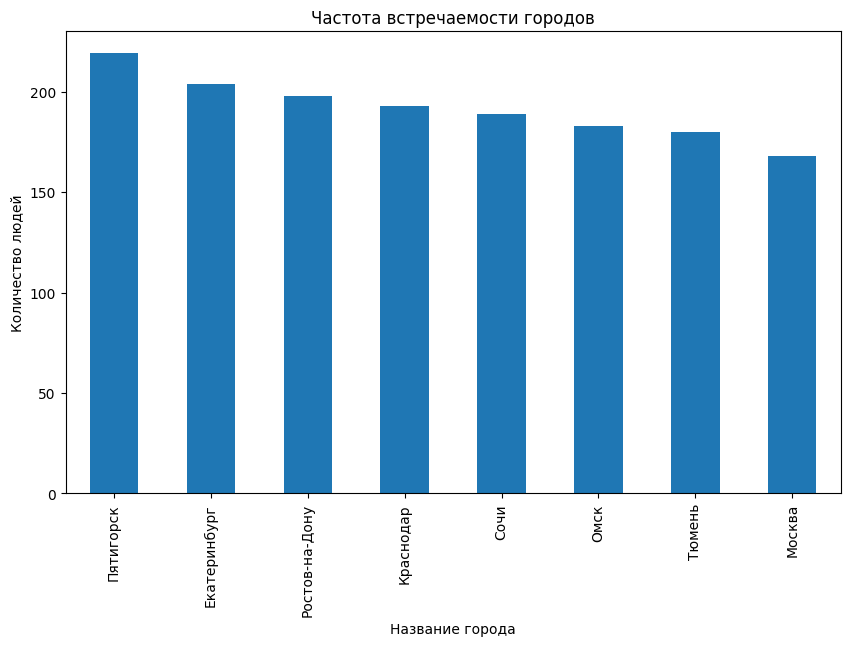

In [10]:
#описываем чистоту встречаемости городов и строим диаграмму
print(data_users['city'].value_counts())
data_users['city'].value_counts().plot(kind='bar', figsize = (10,6), title = 'Частота встречаемости городов', xlabel = 'Название города', ylabel = 'Количество людей')

Как мы видим больше всего клиентов находятся в Пятигорске, в то время как самое меньшое количество клиентов находятся в Москве.

1.1945636623748213


<Axes: title={'center': 'Соотношение пользователей с подпиской и без подписки'}, ylabel='Количество пользователей'>

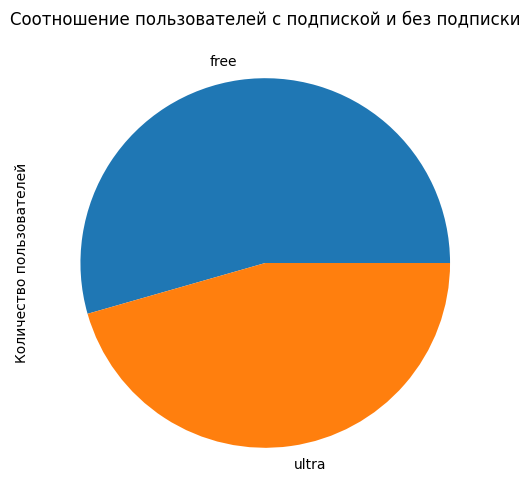

In [11]:
#описываем соотношение пользователей с подпиской и без подписки встречаемости городов и строим диаграмму
subscribers = data_users['subscription_type'].value_counts()
print (subscribers.iloc[0]/subscribers.iloc[1])
data_users['subscription_type'].value_counts().plot(kind='pie', figsize = (10,6), title = 'Соотношение пользователей с подпиской и без подписки',  ylabel = 'Количество пользователей')

Большинство людей используют сервис без подписки, но отрыв не очень большой. Бесплатных пользователей почти в 1.2 больше чем платных.

age
25    145
24    132
26    131
23    129
22    119
27    119
28    112
21     93
20     71
30     68
29     68
31     48
19     47
18     46
32     41
33     39
17     26
16     19
34     19
35     15
15     13
14      9
13      8
36      6
12      4
38      3
37      2
39      1
43      1
Name: count, dtype: int64


<Axes: title={'center': 'Возраст пользователей'}, xlabel='Возраст', ylabel='Количество пользователей'>

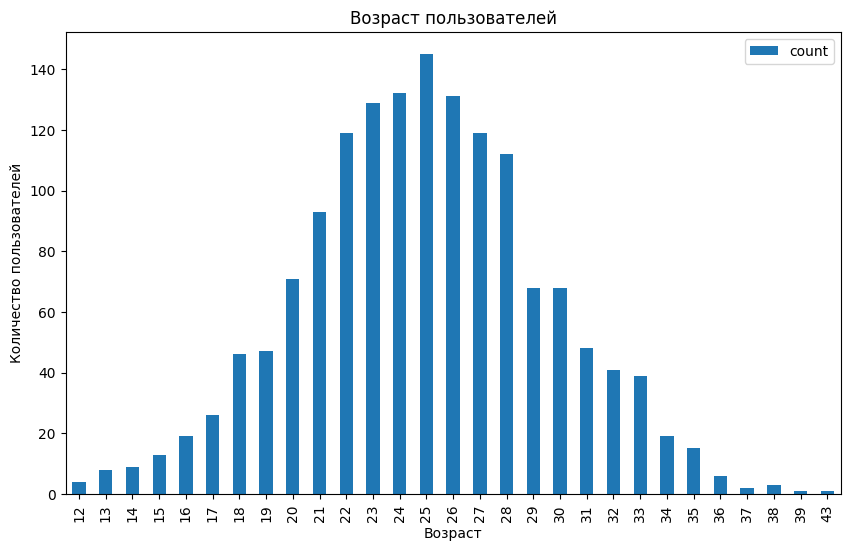

In [12]:
#описываем возраст пользователей и строим диаграмму
print(data_users['age'].value_counts())
age = data_users['age'].value_counts().reset_index()
age.columns = ['age', 'count']
age_sorted = age.sort_values(by = 'age')
age_sorted.plot(kind='bar', figsize = (10,6),x = 'age', y = 'count', title = 'Возраст пользователей', xlabel = 'Возраст', ylabel = 'Количество пользователей')

Целевой аудиторией для сервиса являются люди от 20 до 30 лет, остальные возрастные группы пользуются им не в таком большом количестве. Пик призодится на 25 лет. Распределение нормальное.

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64


Text(0.5, 1.0, 'Расстояние, которое пользователь преодолел за одну поездку')

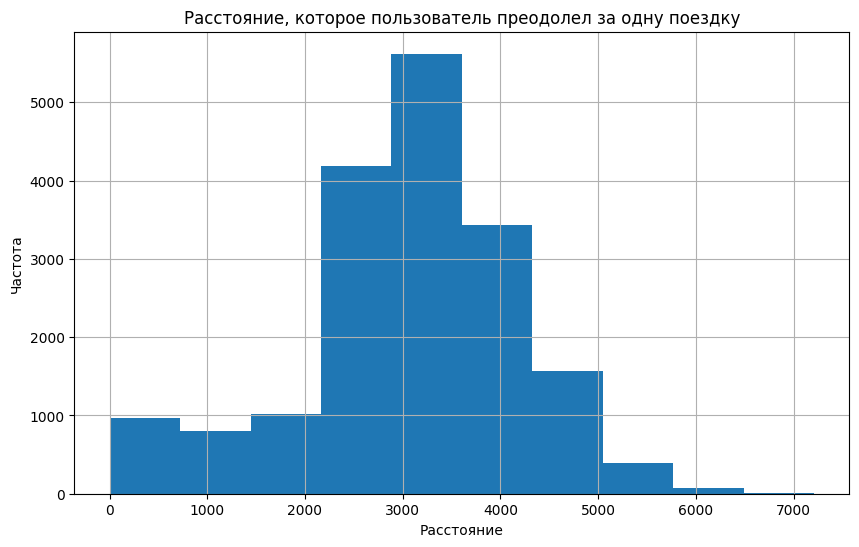

In [13]:
#описываем расстояние поездки пользователей и строим гистограмму
print(data_rides['distance'].describe())
data_rides['distance'].hist(figsize = (10,6))
plt.xlabel('Расстояние')
plt.ylabel('Частота')
plt.title('Расстояние, которое пользователь преодолел за одну поездку')

Самой популярной дистанцией является примерно 3 км. Распределение нормальное.

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64


Text(0.5, 1.0, 'Продолжительность поездок')

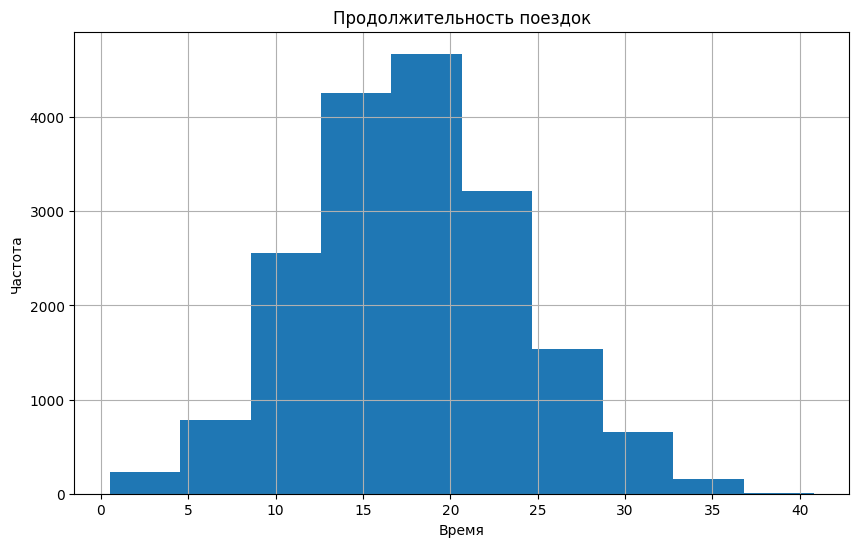

In [14]:
#описываем время поездки пользователей и строим гистограмму
print(data_rides['duration'].describe())
data_rides['duration'].hist(figsize = (10,6))
plt.xlabel('Время')
plt.ylabel('Частота')
plt.title('Продолжительность поездок')

Чаще всего люди проводят за рулём электросамоката от 15 до 20 минут. Распределение нормальное. 

Вывод: в результате исследований мы выяснили, что целевой аудиторией сервиса являются люди от 20 до 30 лет. Больше всего пользователей находятся в Пятигорске, хотя отрыв от других городов не так велик. В основном, люди проезжают за рулём электросамоката около 3 километров, тратя на это от 15 до 20 минут.

#### Шаг 4. Объединение данных

In [15]:
#обьединяем 1 датафрейм со 2
data_0 = pd.merge(data_users, data_rides, how = 'inner', on = 'user_id')
#обьединяем новый датафрейм с 3
data = pd.merge(data_0, data_sub, how = 'inner', on = 'subscription_type')
#проверяем новый датафрейм
print (data.info())
print (data.isnull().sum())
#делаем новый датафрейм с бесплатными подписчиками сервиса
data_sub0 = data[data['subscription_type'] == 'free']
#делаем новый датафрейм с платными подписчиками сервиса
data_sub1 = data[data['subscription_type'] == 'ultra']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   index              18068 non-null  int64         
 1   user_id            18068 non-null  int64         
 2   name               18068 non-null  object        
 3   age                18068 non-null  int64         
 4   city               18068 non-null  object        
 5   subscription_type  18068 non-null  object        
 6   distance           18068 non-null  float64       
 7   duration           18068 non-null  float64       
 8   date               18068 non-null  datetime64[ns]
 9   month              18068 non-null  int32         
 10  minute_price       18068 non-null  int64         
 11  start_ride_price   18068 non-null  int64         
 12  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(6), object(

В новом датафрейме количество строк не изменилось. Пропуски не появились.

Text(0.5, 1.0, 'Расстояние, которое пользователь преодолел за одну поездку(без платной подписки)')

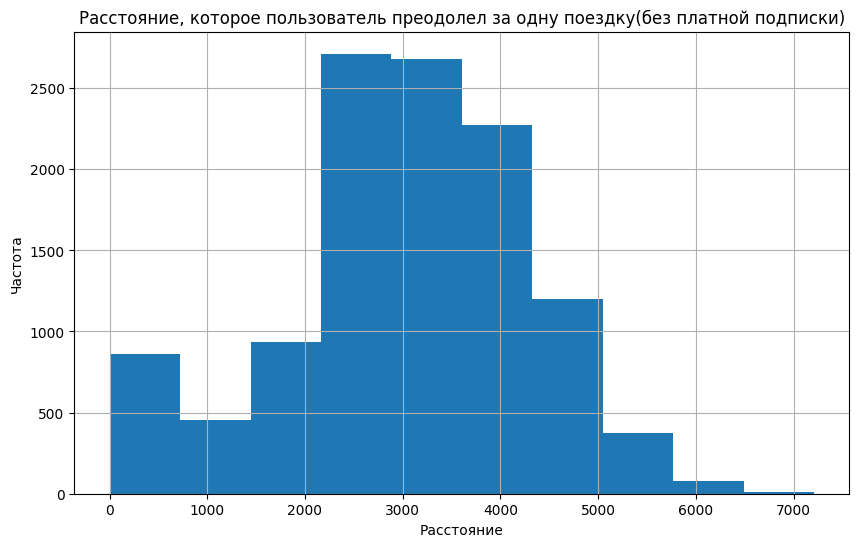

In [16]:
#строим гистограмму для расстояния поездки людей без платной подписки
data_sub0['distance'].hist(figsize = (10,6))
plt.xlabel('Расстояние')
plt.ylabel('Частота')
plt.title('Расстояние, которое пользователь преодолел за одну поездку(без платной подписки)')

Расстояние, в основном, проходят меньше, чем в общей выборке.

Text(0.5, 1.0, 'Продолжительность поездок без платной подписки')

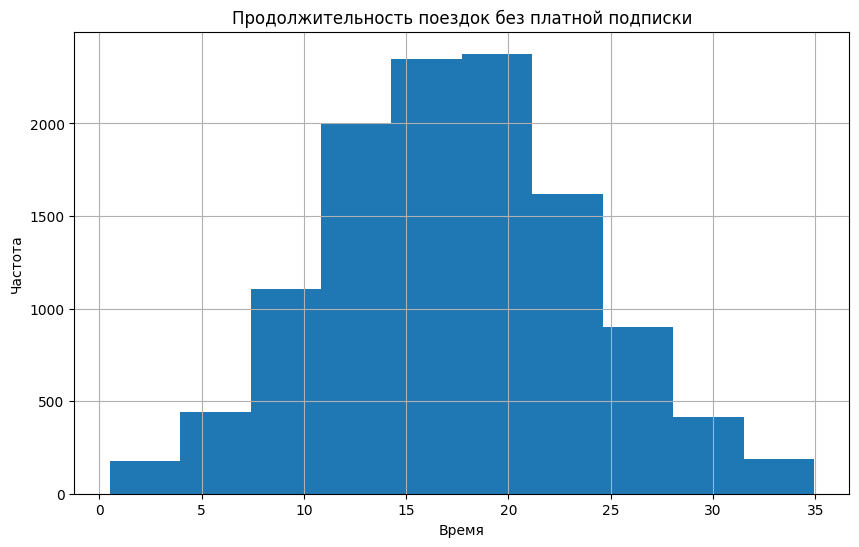

In [17]:
#строим гистограмму для времени поездки людей без платной подписки
data_sub0['duration'].hist(figsize = (10,6))
plt.xlabel('Время')
plt.ylabel('Частота')
plt.title('Продолжительность поездок без платной подписки')

Практически те же данные, что и по общей выборке

Text(0.5, 1.0, 'Расстояние, которое пользователь преодолел за одну поездку(с платной подпиской)')

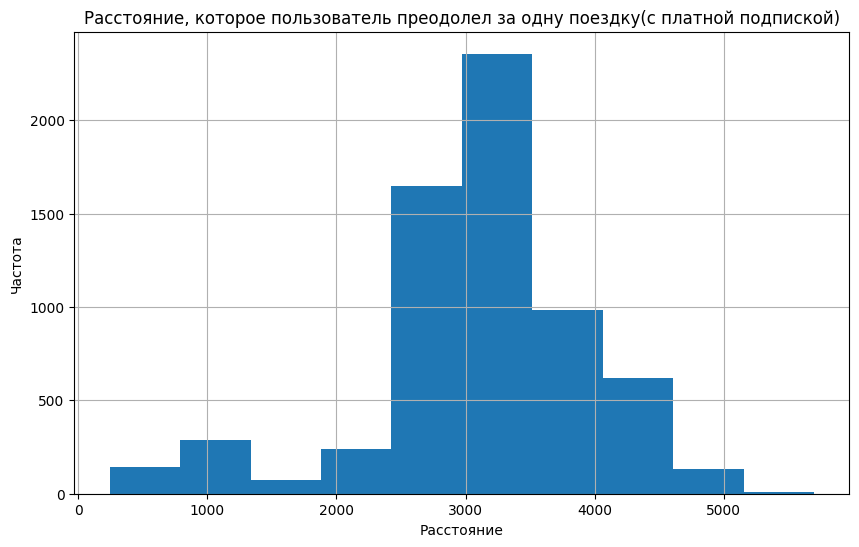

In [18]:
#строим гистограмму для расстояния поездки людей с платной подпиской
data_sub1['distance'].hist(figsize = (10,6))
plt.xlabel('Расстояние')
plt.ylabel('Частота')
plt.title('Расстояние, которое пользователь преодолел за одну поездку(с платной подпиской)')

Расстояние, в основном, проходят меньше, чем в общей выборке.

Text(0.5, 1.0, 'Продолжительность поездок с платной подпиской')

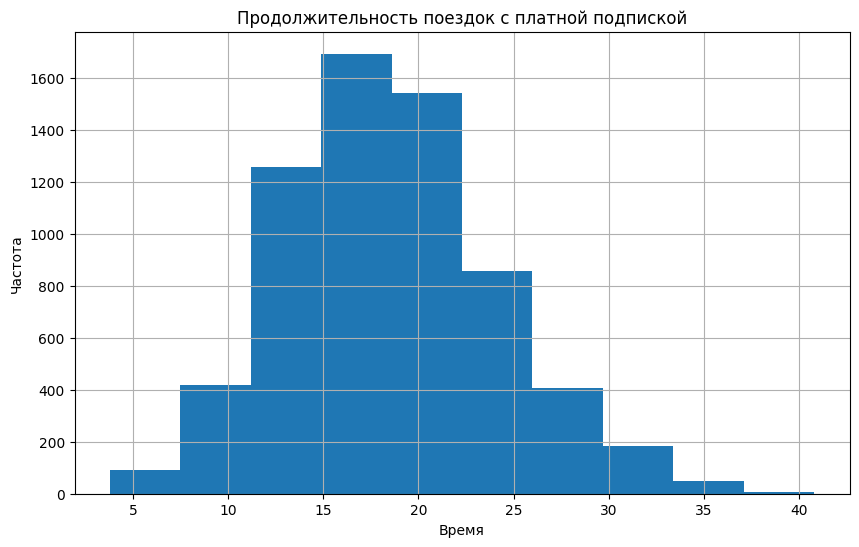

In [19]:
#строим гистограмму для времени поездки людей с платной подпиской
data_sub1['duration'].hist(figsize = (10,6))
plt.xlabel('Время')
plt.ylabel('Частота')
plt.title('Продолжительность поездок с платной подпиской')

Практически те же данные, что и по общей выборке

Вывод: В данном блоке я обьединил 3 искомых датафрейма в один, а так же создали два новых(для пользователей с платной подпиской и без нее). Далее мы изучили два новых датафрейма, данные по времени не так сильно отклоняются от общей выборки, а столбцы с расстояниями отличаются сильно, ведь с платной подпиской люди проезжают большое расстояние, чем при общей выборке, а люди без нее проезжают меньшее расстояние, чем при общей выборке. Так же люди с платной подпиской имеет меньший разброс в километраже, так как проезжают, в основном, похожие маршруты, так как платные подписчики пользуются сервисом на более постоянной основе, чем без нее.

#### Шаг 5. Подсчёт выручки

In [20]:
#строим датафрейм с агрегированными данными(суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.)
data_agr = data.pivot_table(index = ['user_id', 'month'], values = ['date', 'distance', 'duration'], aggfunc = {'date': 'count', 'distance': 'sum', 'duration': 'sum'})
data_agr.columns = ['rides', 'm_dist', 'm_dur']
print(data_agr.isnull().sum())
print(data_agr.head(10))

rides     0
m_dist    0
m_dur     0
dtype: int64
               rides        m_dist      m_dur
user_id month                                
1       1          2   7027.511294  41.416640
        4          1    754.159807   6.232113
        8          2   6723.470560  44.776802
        10         2   5809.911100  31.578017
        11         3   7003.499363  53.397424
        12         2   6751.629942  27.203912
2       3          3  10187.723006  60.959959
        4          2   6164.381824  39.048633
        6          1   3255.338202  13.851127
        7          2   6780.722964  46.170157


Пропущенные значения не появились.

In [21]:
#округляем столбец с временем поездки для подсчёта выручки
data['duration'] = np.ceil(data['duration'])
#строим новый датафрейм для подсчета выручки
data_agr1 = data.pivot_table(index = ['user_id', 'month'], values = ['date', 'distance', 'duration', 'subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee'], aggfunc = {'date': 'count', 'distance':'sum', 'duration':'sum', 'subscription_type':'first', 'minute_price':'first', 'start_ride_price':'first', 'subscription_fee':'first'})
#проверяем на пропуски
print (data_agr1.isnull().sum())
data_agr1.columns = ['rides', 'sum_dist', 'sum_dur','minute_price',  'start_ride_price', 'subscription_fee', 'subscription_type']
#подсчитываем выручки и добавляем в новый столбец
data_agr['revenue'] = data_agr1['start_ride_price']*data_agr1['rides']+data_agr1['minute_price']*data_agr1['sum_dur']+data_agr1['subscription_fee']
#делаем такой же столбец в доп. датафрейме для будущего удобства
data_agr1['revenue'] = data_agr1['start_ride_price']*data_agr1['rides']+data_agr1['minute_price']*data_agr1['sum_dur']+data_agr1['subscription_fee']
print(data_agr)

date                 0
distance             0
duration             0
minute_price         0
start_ride_price     0
subscription_fee     0
subscription_type    0
dtype: int64
               rides        m_dist      m_dur  revenue
user_id month                                         
1       1          2   7027.511294  41.416640    451.0
        4          1    754.159807   6.232113    241.0
        8          2   6723.470560  44.776802    475.0
        10         2   5809.911100  31.578017    391.0
        11         3   7003.499363  53.397424    535.0
...              ...           ...        ...      ...
1534    6          2   3409.468534  24.812678    308.0
        8          2   7622.453034  47.205960    484.0
        9          1   4928.173852  22.560373    234.0
        11         4  13350.015305  76.342174    824.0
        12         1   2371.711192  15.893917    178.0

[11331 rows x 4 columns]


Пропущенные значения не появились.

В данном блоке был создан новый датафрейм с агрегированными данными(суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц). Далее был создан дополнительный датафрейм для подсчёта помесячной выручки с каждого клиента. Далее была подсчитана сама выручка и добавлена в новый стобец в датафрейме с агрегированными данными.

#### Шаг 6. Проверка гипотез

№6.1:
Нулевая гипотеза (H0): Средняя продолжительность сессий для пользователей с подпиской и без нее не различается.

Альтернативная гипотеза (H1): Средняя продолжительность сессий для пользователей с подпиской больше.

In [22]:
# Выполняем t-тест с указанием односторонней альтернативной гипотезы
t_statistic, p_value = stats.ttest_ind(data_sub1['duration'], data_sub0['duration'], alternative='greater')

# Оцениваем результаты теста
alpha = 0.05  # Уровень значимости
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: средняя продолжительность сессий для пользователей с подпиской больше.")
else:
    print("Не отвергаем нулевую гипотезу: средняя продолжительность сессий для пользователей с подпиской и без нее не различается.")
    
print("Значение p-value:", p_value)

Отвергаем нулевую гипотезу: средняя продолжительность сессий для пользователей с подпиской больше.
Значение p-value: 1.2804098316645613e-34


Средняя продолжительность сессий для пользователей с подпиской больше, соответственно гипотеза верна и люди с подпиской могут быть "выгоднее" для компании.

№6.2: Нулевая гипотеза (H0): Среднее расстояние поездки пользователей с подпиской равно 3130 метров.

Альтернативная гипотеза (H1): Среднее расстояние поездки пользователей с подпиской превышает 3130 метров.

In [23]:
# Выполняем t-тест с указанием односторонней альтернативной гипотезы
t_statistic, p_value = stats.ttest_1samp(data_sub1['distance'], 3130, alternative='greater')

# Оцениваем результаты теста
alpha = 0.05  # Уровень значимости
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: среднее расстояние превышает 3130 метров.")
else:
    print("Не отвергаем нулевую гипотезу: среднее расстояние равно 3130 метров.")
    
print("Значение p-value:", p_value)

Не отвергаем нулевую гипотезу: среднее расстояние равно 3130 метров.
Значение p-value: 0.9195368847849785


Не отвергаем нулевую гипотезу среднее расстояние людей с подписками не превышает 3130 (нулевая гипотеза декларирует равенство,а она подтвердилась, это не значит, что среднее именно равно этому числу, тест был на превышение, оно не подтвердилось), что очень хорошо для компании, ведь эти показатели очень хороши для износа самокатов.

№6.3: Нулевая гипотеза (H0): Средняя помесячная выручка от пользователей с подпиской не отличается от средней помесячной выручки от пользователей без подписки.

Альтернативная гипотеза (H1): Средняя помесячная выручка от пользователей с подпиской выше, чем средняя помесячная выручка от пользователей без подписки.

In [24]:
#делаем дополнительные датафреймы для проверки гипотезы
data_agr1_sub0 = data_agr1[data_agr1['subscription_type'] == 'free']
data_agr1_sub1 = data_agr1[data_agr1['subscription_type'] == 'ultra']

# Выполняем t-тест
t_statistic, p_value = stats.ttest_ind(data_agr1_sub1['revenue'], data_agr1_sub0['revenue'], alternative = 'greater')
# Оцениваем результаты теста
alpha = 0.05  # Уровень значимости
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: средняя помесячная выручка от пользователей с подпиской выше.")
else:
    print("Не отвергаем нулевую гипотезу: средняя помесячная выручка от пользователей с подпиской не отличается от средней помесячной выручки от пользователей без подписки.")

Отвергаем нулевую гипотезу: средняя помесячная выручка от пользователей с подпиской выше.


Средняя выручка от пользователей с подпиской выше, что так же делает их "выгоднее" для компании.

№6.4: Односторонний t-тест(st.ttest_rel()).

Гипотезы:

Нулевая гипотеза (H0): Среднее количество обращений после обновления серверов такое же как до обновления.

Альтернативная гипотеза (H1): Среднее количество обращений после обновления серверов меньше, чем до обновления.

Теперь используем односторонний t-тест на равенство средних для зависимых выборок, до и после изменений (st.ttest_rel()) для проверки этой гипотезы, с учетом того, что мы интересуемся снижением показателей:

Если p-значение меньше выбранного уровня значимости (alpha), то вы сможете отвергнуть нулевую гипотезу и сделать вывод о статистически значимом снижении показателей.

Если p-значение больше alpha, то не отвергнем нулевую гипотезу и скажем, что статистически значимого снижения показателей не обнаружено.

Вывод: После проверки нескольких гипотез, видно, что клиенты с подпиской гораздо прибыльнее, нежели клиенты без нее, по всем проверенным гипотезам.

Общий вывод: в данном проекте я изучил и обработал данные о сервисе электросамокатов. Я изучил и предобработал данные(уничтожили все аномалии в данных). Исследовали информацию о клинетах сервиса(целевая аудитория - 20-30 лет, самый популярный город - Пятигорск, самые популярные расстояние и время поездки - 3 км и 15-20 минут соответственно). Далее, после обьединения старых и создания новых датафреймов, я выяснил, что платные подписчики более постоянны в своих поездках и проезжают больший километраж. Далее я создал новый датафрейм с помесячной вырочкой от каждого клиента и новый датафрейм с агрегированными данными (суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц).

Главной частью данного проекта было решение главного вопроса - являются ли пользователи с подпиской "выгоднее" для компании, и, благодаря проверке гипотез, я уверен, что пользователи с подпиской и правда прибыльнее для компании. Это доказывается тем, что пользователи с подпиской проводят больше времени за рулём электросамоката, чем пользователи без нее, что выгодно для компании, ведь на самокаты поминутная аренда. Так же стоит отметить, что проезжают пользователи с подпиской не более 3130 метров за сессию, что очень хорошо, с точки зрения износа самоката. В конце концов помесячная выручка от людей с подпиской выше, что является очень важным показателям для компании. Еще можно учесть, что постоянность маршрутов людьми с подпиской выше, нежели без нее, что видно на графиках, это принесёт компании дополнительную стабильность.